## GB_FX Price only Monthly


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Data (B): 1999-01-04 → 2024-12-31 | n=6782
Data (D): 1999-01-04 → 2024-12-31 | n=9494

Dropped months and reasons:
  1999-01: no_cut_in_prev_month
  1999-02: hist<200
  1999-03: hist<200
  1999-04: hist<200
  1999-05: hist<200
  1999-06: hist<200
  1999-07: hist<200

=== Model performance (monthly mean, EUR/NOK) ===
Observations: 305
RMSE (level): 0.164162
MAE  (level): 0.107799
Directional accuracy: 205/304 (67.4%)

=== Diebold–Mariano vs Random Walk ===
Loss: MSE | horizon h=1
DM-statistic: 0.2693
p-value     : 0.7877


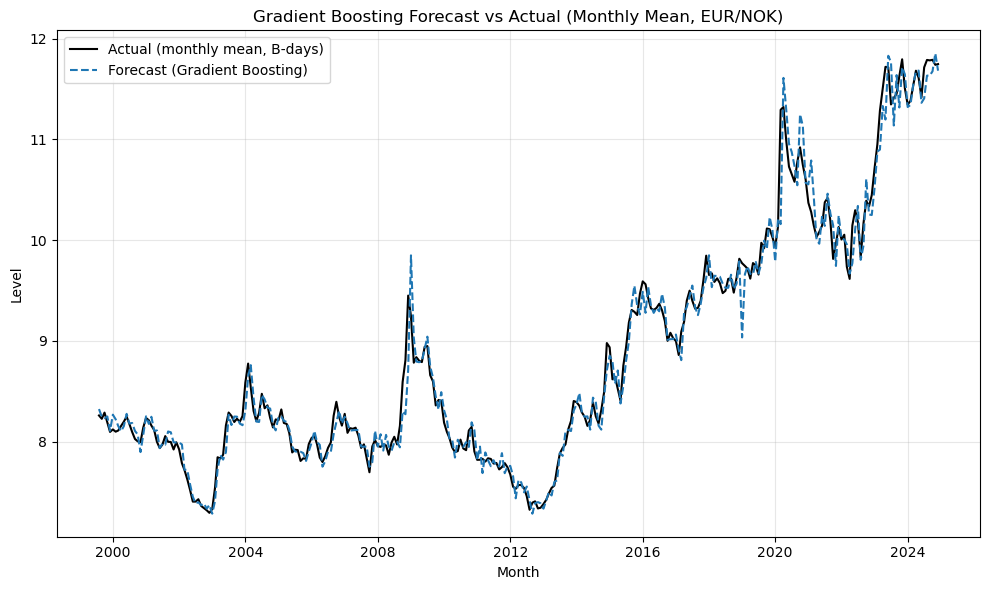

Saved: GB_Monthly.png
Saved: GB_Monthly.pdf


In [1]:
# =========================================
# Gradient Boosting – EUR/NOK walk-forward (monthly, levels), point forecast only
# PARALLEL OUTER LOOP
# - Data: GitHub CSV (semicolon-separated; decimal comma), forward-filled to daily
# - Cut: last business day of previous month
# - Model: GradientBoostingRegressor on daily lag features
# - Forecast: recursive daily next-month -> aggregate to monthly mean over business days
# - Metrics: Observations, RMSE, MAE, Directional accuracy
# - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
# - Plot: Actual (black) vs Forecast (blue dashed), no intervals
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = "https://raw.githubusercontent.com/bredeespelid/Data_MasterOppgave/refs/heads/main/EURNOK/EUR_NOK_NorgesBank.csv"
    m_freq: str = "M"                 # monthly evaluation
    min_hist_days: int = 200          # GB needs more history than Chronos
    max_lags: int = 20                # number of daily lags used as features

    # Gradient Boosting hyperparameters (tune if needed)
    n_estimators: int = 800
    learning_rate: float = 0.03
    max_depth: int = 3                # tree depth per boosting stage
    subsample: float = 0.8            # stochastic GB
    min_samples_leaf: int = 2
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "GB_Monthly.png"
    fig_pdf: str = "GB_Monthly.pdf"

CFG = Config()

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.Series]:
    """
    Load Norges Bank CSV (semicolon-separated; decimal comma) with columns TIME_PERIOD, OBS_VALUE.
    Returns:
      S_b: business-day (B) with ffill (used for cuts and monthly ground truth)
      S_d: daily (D) with ffill (model inputs and daily forecasts)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=';', encoding='utf-8-sig', decimal=',')

    df = (raw[['TIME_PERIOD', 'OBS_VALUE']]
          .rename(columns={'OBS_VALUE': 'EUR_NOK'})
          .assign(TIME_PERIOD=lambda x: pd.to_datetime(x['TIME_PERIOD'], errors='coerce'))
          .dropna(subset=['TIME_PERIOD', 'EUR_NOK'])
          .sort_values('TIME_PERIOD')
          .set_index('TIME_PERIOD'))

    # Business-day series (truth/aggregation base)
    S_b = df['EUR_NOK'].asfreq('B').ffill().astype(float)
    S_b.name = 'EUR_NOK'

    # Daily series (model inputs / daily forecasts)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq='D')
    S_d = df['EUR_NOK'].reindex(full_idx).ffill().astype(float)
    S_d.index.name = 'DATE'
    S_d.name = 'EUR_NOK'
    return S_b, S_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Feature engineering (lags)
# -----------------------------
def make_lag_matrix(y: pd.Series, max_lags: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Build X, y_target for one-step ahead forecasting:
      X_t = [y_{t-1}, ..., y_{t-max_lags}]
      y_target = y_t
    """
    df = pd.DataFrame({'y': y})
    for k in range(1, max_lags + 1):
        df[f'lag{k}'] = df['y'].shift(k)
    df = df.dropna()
    X = df[[f'lag{k}' for k in range(1, max_lags + 1)]].values
    y_target = df['y'].values
    return X, y_target

# -----------------------------
# Gradient Boosting one-step model
# -----------------------------
def fit_gb_one_step(y_hist_daily: pd.Series) -> GradientBoostingRegressor:
    """
    Fit Gradient Boosting for one-step ahead daily prediction.
    GradientBoostingRegressor is single-threaded by design,
    which is good for outer-loop parallelization.
    """
    X, y_target = make_lag_matrix(y_hist_daily, CFG.max_lags)
    model = GradientBoostingRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        min_samples_leaf=CFG.min_samples_leaf,
        random_state=CFG.random_state,
    )
    model.fit(X, y_target)
    return model

def recursive_daily_forecast(model: GradientBoostingRegressor, y_hist_daily: pd.Series, H: int) -> pd.Series:
    """
    Produce H daily forecasts recursively:
      - start from last max_lags observed values
      - each step uses previous predicted value as newest lag
    """
    hist = y_hist_daily.values.tolist()
    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")
        x = np.array(hist[-CFG.max_lags:][::-1], dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)
        hist.append(yhat)
    return pd.Series(preds)

# -----------------------------
# Monthly walk-forward using GB (PARALLEL outer loop)
# -----------------------------
def walk_forward_gb_monthly_parallel(S_b: pd.Series, S_d: pd.Series, n_jobs_outer: int = -1) -> pd.DataFrame:
    """
    For each calendar month m:
      - cut at last business day of previous month
      - fit GB on daily history up to cut
      - recursively forecast full calendar month at daily frequency
      - aggregate to business-day monthly mean and compare to truth

    Outer loop parallelization:
      - each month is independent and computed in parallel.
    """
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    def _process_one_month(m: pd.Period):
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(m), None, "no_cut_in_prev_month")

        hist_d = S_d.loc[:cut]
        if hist_d.size < CFG.min_hist_days:
            return (str(m), None, f"hist<{CFG.min_hist_days}")

        # Business days inside target month
        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            return (str(m), None, "no_bdays_in_month")
        y_true = float(S_b.loc[idx_m_b].mean())

        # Horizon = full calendar month length (inclusive)
        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0:
            return (str(m), None, f"horizon_invalid(H={H})")

        # Fit model on daily history up to cut
        model = fit_gb_one_step(hist_d)

        # Recursive daily forecast for next month
        pf = recursive_daily_forecast(model, hist_d, H)

        # Index daily forecast from cut+1 over H calendar days
        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq='D')
        pred_daily = pd.Series(pf.values, index=f_idx, name='point')

        # Aggregate forecast to business-day mean over the month
        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            return (str(m), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(m), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend="loky")(
        delayed(_process_one_month)(m) for m in months
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient='index')
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if str(m) not in rows]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true: pd.Series, y_model: pd.Series, y_rw: pd.Series, h: int = 1, loss: str = "mse"):
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple NW/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    """Random walk benchmark = previous month's observed level (y_{t-1})."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (monthly mean)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--", label="Forecast (Gradient Boosting)")

    plt.title("Gradient Boosting Forecast vs Actual (Monthly Mean, EUR/NOK)")
    plt.xlabel("Month")
    plt.ylabel("Level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Data
    S_b, S_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {S_d.index.min().date()} → {S_d.index.max().date()} | n={len(S_d)}")

    # 2) Monthly walk-forward and evaluation (parallel)
    df_eval = walk_forward_gb_monthly_parallel(S_b, S_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    # 3) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # 4) Plot
    plot_monthly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()


## GB_FX Price only Quarterly


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Data (B): 1999-01-04 → 2024-12-31 | n=6782
Data (D): 1999-01-04 → 2024-12-31 | n=9494

Dropped quarters and reasons:
  1999Q1: no_cut_in_prev_quarter
  1999Q2: hist<400
  1999Q3: hist<400
  1999Q4: hist<400
  2000Q1: hist<400

=== Model performance (quarterly mean, EUR/NOK) ===
Observations: 99
RMSE (level): 0.248235
MAE  (level): 0.164538
Directional accuracy: 72/98 (73.5%)

=== Diebold–Mariano vs Random Walk ===
Loss: MSE | horizon h=1
DM-statistic: 0.1933
p-value     : 0.8467


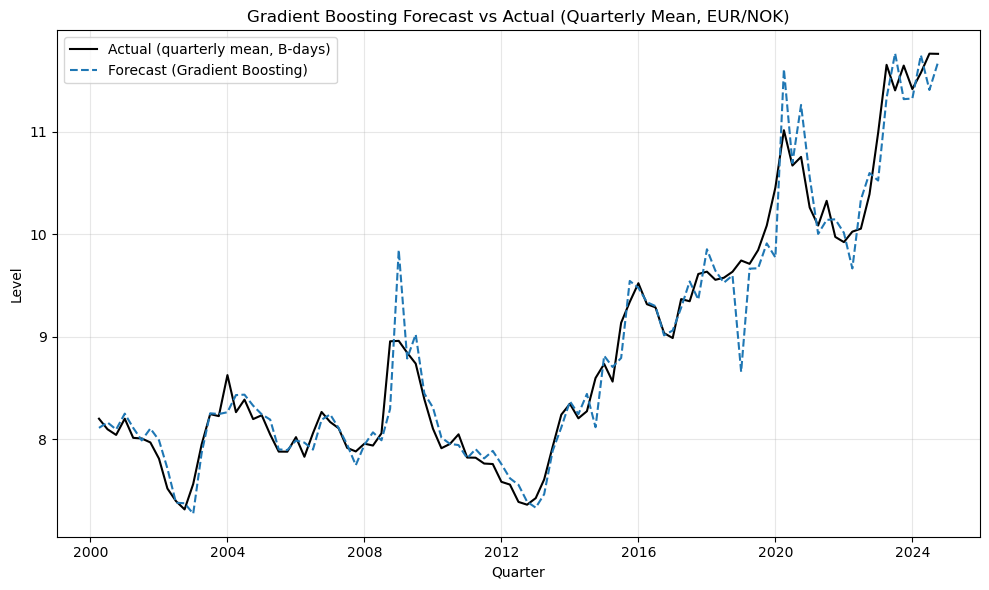

Saved: GB_Quarterly.png
Saved: GB_Quarterly.pdf


In [2]:
# =========================================
# Gradient Boosting – EUR/NOK walk-forward (quarterly, levels), point forecast only
# PARALLEL OUTER LOOP
# - Data: GitHub CSV (semicolon-separated; decimal comma), forward-filled to daily
# - Cut: last business day of previous quarter
# - Model: GradientBoostingRegressor on daily lag features
# - Forecast: recursive daily next-quarter -> aggregate to quarterly mean over business days
# - Metrics: Observations, RMSE, MAE, Directional accuracy
# - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
# - Plot: Actual (black) vs Forecast (blue dashed), no intervals
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/Data_MasterOppgave/"
        "refs/heads/main/EURNOK/EUR_NOK_NorgesBank.csv"
    )
    q_freq: str = "Q-DEC"      # Quarterly evaluation frequency
    min_hist_days: int = 400   # GB needs more history than high-frequency models
    max_lags: int = 20         # Number of daily lags used as features

    # Gradient Boosting hyperparameters
    n_estimators: int = 800
    learning_rate: float = 0.03
    max_depth: int = 3
    subsample: float = 0.8
    min_samples_leaf: int = 2
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "GB_Quarterly.png"
    fig_pdf: str = "GB_Quarterly.pdf"

CFG = Config()

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.Series]:
    """
    Load Norges Bank CSV (semicolon-separated; decimal comma) with columns TIME_PERIOD, OBS_VALUE.
    Returns:
      S_b: Business-day (B) series with ffill (used for cuts and quarterly ground truth)
      S_d: Daily (D) series with ffill (model inputs and daily forecasts)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=';', encoding='utf-8-sig', decimal=',')

    required_cols = {"TIME_PERIOD", "OBS_VALUE"}
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (raw[['TIME_PERIOD', 'OBS_VALUE']]
          .rename(columns={'OBS_VALUE': 'EUR_NOK'})
          .assign(TIME_PERIOD=lambda x: pd.to_datetime(x['TIME_PERIOD'], errors='coerce'))
          .dropna(subset=['TIME_PERIOD', 'EUR_NOK'])
          .sort_values('TIME_PERIOD')
          .set_index('TIME_PERIOD'))

    # Business-day series (truth / aggregation base)
    S_b = df['EUR_NOK'].asfreq('B').ffill().astype(float)
    S_b.name = 'EUR_NOK'

    # Daily series (model inputs / daily forecasts)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq='D')
    S_d = df['EUR_NOK'].reindex(full_idx).ffill().astype(float)
    S_d.index.name = 'DATE'
    S_d.name = 'EUR_NOK'
    return S_b, S_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Feature engineering (lags)
# -----------------------------
def make_lag_matrix(y: pd.Series, max_lags: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Construct X and y_target for one-step ahead forecasting:
      X_t = [y_{t-1}, ..., y_{t-max_lags}]
      y_target = y_t
    """
    df = pd.DataFrame({'y': y})
    for k in range(1, max_lags + 1):
        df[f'lag{k}'] = df['y'].shift(k)
    df = df.dropna()
    X = df[[f'lag{k}' for k in range(1, max_lags + 1)]].values
    y_target = df['y'].values
    return X, y_target

# -----------------------------
# Gradient Boosting one-step model
# -----------------------------
def fit_gb_one_step(y_hist_daily: pd.Series) -> GradientBoostingRegressor:
    """Fit Gradient Boosting for one-step ahead daily prediction."""
    X, y_target = make_lag_matrix(y_hist_daily, CFG.max_lags)
    model = GradientBoostingRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        min_samples_leaf=CFG.min_samples_leaf,
        random_state=CFG.random_state,
    )
    model.fit(X, y_target)
    return model

def recursive_daily_forecast(model: GradientBoostingRegressor, y_hist_daily: pd.Series, H: int) -> pd.Series:
    """
    Produce H daily forecasts recursively:
      - start from last max_lags observed values
      - each step uses previous predicted value as newest lag
    """
    hist = y_hist_daily.values.tolist()
    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")
        x = np.array(hist[-CFG.max_lags:][::-1], dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)
        hist.append(yhat)
    return pd.Series(preds)

# -----------------------------
# Quarterly walk-forward using GB (PARALLEL outer loop)
# -----------------------------
def walk_forward_gb_quarterly_parallel(
    S_b: pd.Series,
    S_d: pd.Series,
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    """
    For each calendar quarter q:
      - cut at last business day of previous quarter
      - fit GB on daily history up to cut
      - recursively forecast full calendar quarter at daily frequency
      - aggregate to business-day quarterly mean and compare to truth

    Outer loop is parallelized: each quarter is computed independently.
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    def _process_one_quarter(q: pd.Period):
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(q), None, "no_cut_in_prev_quarter")

        hist_d = S_d.loc[:cut]
        if hist_d.size < CFG.min_hist_days:
            return (str(q), None, f"hist<{CFG.min_hist_days}")

        # Business days inside target quarter
        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            return (str(q), None, "no_bdays_in_quarter")
        y_true = float(S_b.loc[idx_q_b].mean())

        # Horizon = full calendar quarter length (inclusive)
        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0:
            return (str(q), None, f"horizon_invalid(H={H})")

        # Fit model on daily history up to cut
        model = fit_gb_one_step(hist_d)

        # Recursive daily forecast for next quarter
        pf = recursive_daily_forecast(model, hist_d, H)

        # Index daily forecasts from cut+1 over H calendar days
        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq='D')
        pred_daily = pd.Series(pf.values, index=f_idx, name='point')

        # Aggregate forecast to business-day mean over the quarter
        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            return (str(q), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(q), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_quarter)(q) for q in quarters
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient='index')
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if str(q) not in rows]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple NW/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """Random walk benchmark = previous quarter's observed level (y_{t-1})."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (quarterly mean)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--", label="Forecast (Gradient Boosting)")

    plt.title("Gradient Boosting Forecast vs Actual (Quarterly Mean, EUR/NOK)")
    plt.xlabel("Quarter")
    plt.ylabel("Level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Load data
    S_b, S_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {S_d.index.min().date()} → {S_d.index.max().date()} | n={len(S_d)}")

    # 2) Quarterly walk-forward and evaluation (parallel outer loop)
    df_eval = walk_forward_gb_quarterly_parallel(S_b, S_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    # 3) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # 4) Plot
    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()


## GB_FX Macro Monthly


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['EUR_NOK', 'dI_t', 'd_pi', 'Q']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<400
  2000-03: hist<400
  2000-04: hist<400
  2000-05: hist<400
  2000-06: hist<400
  2000-07: hist<400
  2000-08: hist<400
  2000-09: hist<400
  2000-10: hist<400
  2000-11: hist<400
  2000-12: hist<400
  2001-01: hist<400
  2001-02: hist<400
  2001-03: hist<400

=== Model performance (monthly mean, EUR/NOK – GB past macro covariates) ===
Observations: 296
RMSE (level): 0.164386
MAE  (level): 0.107797
Directional accuracy: 200/295 (67.8%)

=== Diebold–Mariano vs Random Walk (GB past macro covariates, monthly) ===
Loss: MSE | horizon h=1
DM-statistic: -0.1843
p-value     : 0.8538


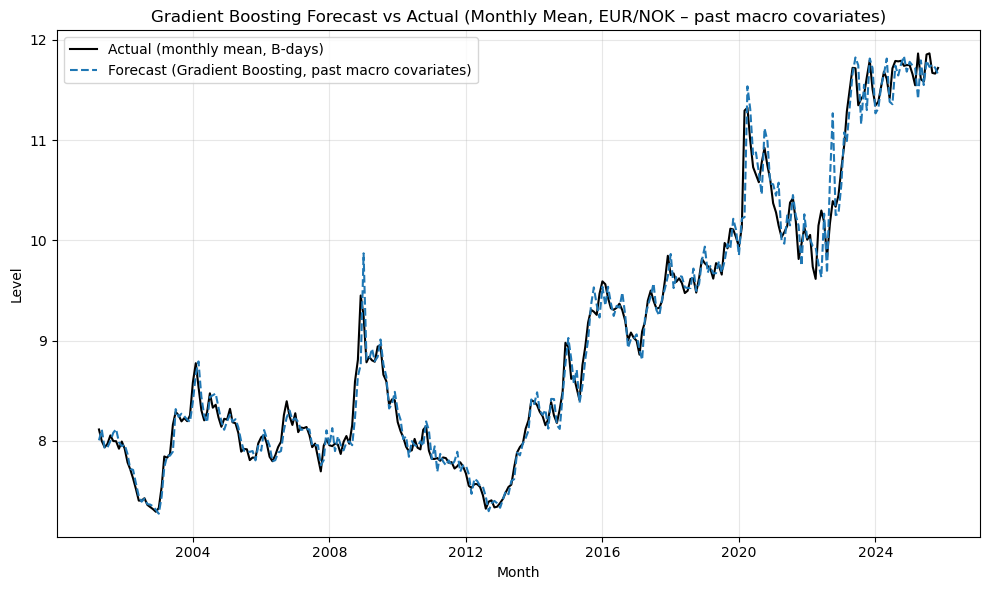

Saved: GB_M_daily_pastcov.png
Saved: GB_M_daily_pastcov.pdf


In [3]:
# =========================================
# Gradient Boosting – EUR/NOK walk-forward (monthly, levels) with daily macro covariates
# PARALLEL OUTER LOOP
# Univariate setup:
#   - Target: EUR_NOK (single series)
#   - Macros: Q, d_pi, dI_t as past-only covariates
#   - Data: daily (calendar days), forward-filled
#   - Cut: last business day of previous month (based on EUR_NOK B-days)
#   - Forecast: next calendar month at daily frequency (recursive one-step GB),
#               aggregated to monthly mean over business days (EUR/NOK)
#   - No future macro paths used -> macros are frozen at last observed value during recursion
#   - Metrics: Observations, RMSE, MAE, Directional accuracy
#   - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
#   - Plot: Actual (black) vs Forecast (blue dashed), no intervals
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    m_freq: str = "M"
    min_hist_days: int = 400   # GB + macros need more history to stabilize
    max_lags: int = 20         # Number of daily lags per variable

    # Gradient Boosting hyperparameters
    n_estimators: int = 800
    learning_rate: float = 0.03
    max_depth: int = 3
    subsample: float = 0.8
    min_samples_leaf: int = 2
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "GB_M_daily_pastcov.png"
    fig_pdf: str = "GB_M_daily_pastcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
MACRO_COLS = ["Q", "d_pi", "dI_t"]

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading: daily EUR_NOK (B + D) + macro covariates
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV with columns:
      Date, EUR_NOK, Q, d_pi, dI_t

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (for cuts and monthly ground truth)
      DF_d : daily (D) DataFrame with columns [EUR_NOK, Q, d_pi, dI_t],
             calendar days, forward-filled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", "EUR_NOK", "Q", "d_pi", "dI_t"}
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", "EUR_NOK"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types
    for col in [TARGET_SERIES] + MACRO_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK (truth / aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily DF_d (calendar days, forward-filled)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Feature engineering (multivariate lags)
# -----------------------------
def make_lag_matrix(df_hist: pd.DataFrame, max_lags: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Build X, y_target for one-step ahead daily forecasting.

    For each t:
      X_t = [EUR_NOK_{t-1..t-L}, Q_{t-1..t-L}, d_pi_{t-1..t-L}, dI_t_{t-1..t-L}]
      y_target = EUR_NOK_t
    """
    work = df_hist[[TARGET_SERIES] + MACRO_COLS].copy()
    lag_cols: List[str] = []

    for var in [TARGET_SERIES] + MACRO_COLS:
        for k in range(1, max_lags + 1):
            name = f"{var}_lag{k}"
            work[name] = work[var].shift(k)
            lag_cols.append(name)

    work = work.dropna()
    X = work[lag_cols].values
    y_target = work[TARGET_SERIES].values
    return X, y_target

# -----------------------------
# Gradient Boosting one-step model
# -----------------------------
def fit_gb_one_step(df_hist_daily: pd.DataFrame) -> GradientBoostingRegressor:
    """Fit GB for one-step ahead daily prediction using lagged target + lagged macros."""
    X, y_target = make_lag_matrix(df_hist_daily, CFG.max_lags)
    model = GradientBoostingRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        min_samples_leaf=CFG.min_samples_leaf,
        random_state=CFG.random_state,
    )
    model.fit(X, y_target)
    return model

def recursive_daily_forecast(model: GradientBoostingRegressor, df_hist_daily: pd.DataFrame, H: int) -> pd.Series:
    """
    Produce H daily forecasts recursively.

    Anti-leakage rule:
      - Macros are past-only covariates.
      - During recursion we freeze macro values at their last observed level.
    """
    hist = df_hist_daily[[TARGET_SERIES] + MACRO_COLS].copy()

    # Last observed macro levels (frozen into the future)
    last_macros = hist[MACRO_COLS].iloc[-1].to_dict()

    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")

        # Build one-step feature vector using the last L lags of each variable
        row_feats = []
        for var in [TARGET_SERIES] + MACRO_COLS:
            lags = hist[var].iloc[-CFG.max_lags:][::-1].values  # [t-1, ..., t-L]
            row_feats.extend(lags.tolist())

        x = np.array(row_feats, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        # Append predicted target; append frozen macros
        new_row = {TARGET_SERIES: yhat}
        for mc in MACRO_COLS:
            new_row[mc] = last_macros[mc]

        hist = pd.concat(
            [hist, pd.DataFrame([new_row], index=[hist.index[-1] + pd.Timedelta(days=1)])]
        )

    return pd.Series(preds)

# -----------------------------
# Monthly walk-forward using GB + past macros (PARALLEL outer loop)
# -----------------------------
def walk_forward_gb_monthly_pastcov_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    """
    For each calendar month m:
      - cut at last business day of previous month
      - fit GB on daily history up to cut (EUR_NOK + macros)
      - recursively forecast full next month at daily frequency
      - aggregate to business-day monthly mean and compare to truth

    Outer loop is parallelized: each month is computed independently.
    """
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    def _process_one_month(m: pd.Period):
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(m), None, "no_cut_in_prev_month")

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] < CFG.min_hist_days:
            return (str(m), None, f"hist<{CFG.min_hist_days}")

        # Business days in the target month
        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            return (str(m), None, "no_bdays_in_month")
        y_true = float(S_b.loc[idx_m_b].mean())

        # Horizon = full calendar month length (inclusive)
        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0:
            return (str(m), None, f"horizon_invalid(H={H})")

        # Fit GB and forecast recursively
        model = fit_gb_one_step(hist_df)
        pf = recursive_daily_forecast(model, hist_df, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        # Aggregate forecast to business-day mean
        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            return (str(m), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(m), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_month)(m) for m in months
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if str(m) not in rows]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK – GB past macro covariates) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple Newey–West/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """Random walk benchmark = previous month's observed level (y_{t-1})."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (GB past macro covariates, monthly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (monthly mean)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"],
        color="tab:blue", linestyle="--",
        label="Forecast (Gradient Boosting, past macro covariates)"
    )

    plt.title("Gradient Boosting Forecast vs Actual (Monthly Mean, EUR/NOK – past macro covariates)")
    plt.xlabel("Month")
    plt.ylabel("Level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Load data
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # 2) Monthly walk-forward and evaluation (parallel outer loop)
    df_eval = walk_forward_gb_monthly_pastcov_parallel(S_b, DF_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    # 3) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # 4) Plot
    plot_monthly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()


## GB_Fx-Quarterly_Macro



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['EUR_NOK', 'dI_t', 'd_pi', 'Q']

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter
  2000Q2: hist<400
  2000Q3: hist<400
  2000Q4: hist<400
  2001Q1: hist<400

=== Model performance (quarterly mean, EUR/NOK – GB past macro covariates) ===
Observations: 99
RMSE (level): 0.249750
MAE  (level): 0.175566
Directional accuracy: 66/98 (67.3%)

=== Diebold–Mariano vs Random Walk (GB past macro covariates, quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: 0.3187
p-value     : 0.7500


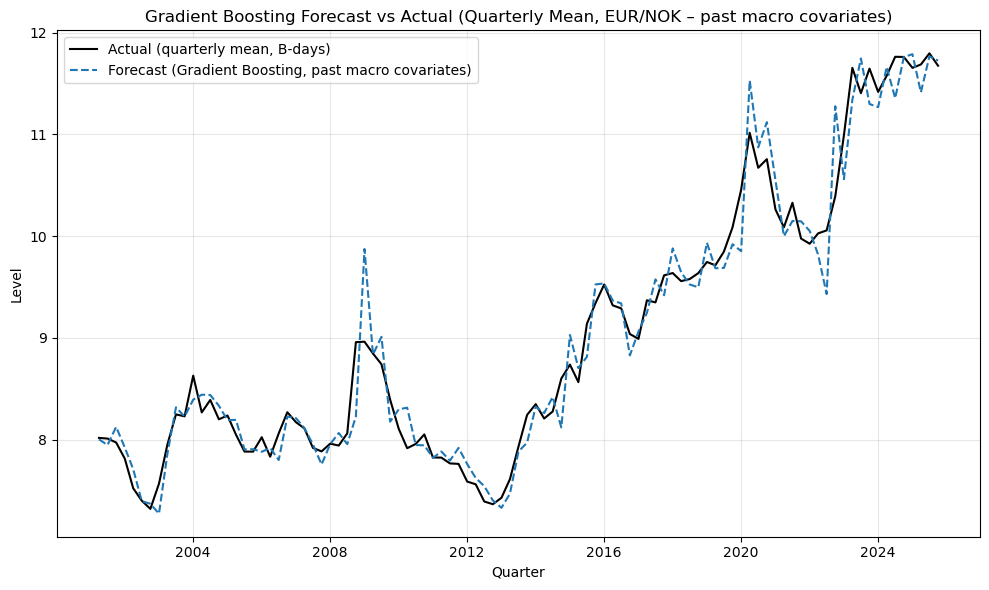

Saved: GB_Q_daily_pastcov.png
Saved: GB_Q_daily_pastcov.pdf


In [4]:
# =========================================
# Gradient Boosting – EUR/NOK walk-forward (quarterly, levels) with daily macro covariates
# PARALLEL OUTER LOOP
# Univariate setup:
#   - Target: EUR_NOK (single series)
#   - Macros: Q, d_pi, dI_t as past-only covariates
#   - Data: daily (calendar days), forward-filled
#   - Cut: last business day of previous quarter (based on EUR_NOK B-days)
#   - Forecast: next calendar quarter at daily frequency (recursive one-step GB),
#               aggregated to quarterly mean over business days (EUR/NOK)
#   - No future macro paths used -> macros are frozen at last observed value during recursion
#   - Metrics: Observations, RMSE, MAE, Directional accuracy
#   - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
#   - Plot: Actual (black) vs Forecast (blue dashed), no intervals
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    q_freq: str = "Q-DEC"      # Quarterly evaluation
    min_hist_days: int = 400   # GB + macro needs more history to stabilize
    max_lags: int = 20         # Number of daily lags per variable
    max_horizon: int = 128     # Must exceed longest quarter (~92 days)

    # Gradient Boosting hyperparameters
    n_estimators: int = 1200
    learning_rate: float = 0.03
    max_depth: int = 3
    subsample: float = 0.8
    min_samples_leaf: int = 2
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "GB_Q_daily_pastcov.png"
    fig_pdf: str = "GB_Q_daily_pastcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
MACRO_COLS = ["Q", "d_pi", "dI_t"]

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading: daily EUR_NOK (B + D) + macro covariates
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV with columns:
      Date, EUR_NOK, Q, d_pi, dI_t

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (for cuts and quarterly ground truth)
      DF_d : daily (D) DataFrame with columns [EUR_NOK, Q, d_pi, dI_t],
             calendar days, forward-filled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", "EUR_NOK", "Q", "d_pi", "dI_t"}
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", "EUR_NOK"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types
    for col in [TARGET_SERIES] + MACRO_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK (truth / aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily DF_d (calendar days, forward-filled)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Feature engineering (multivariate lags)
# -----------------------------
def make_lag_matrix(df_hist: pd.DataFrame, max_lags: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Build X, y_target for one-step ahead daily forecasting.

    For each t:
      X_t = [EUR_NOK_{t-1..t-L}, Q_{t-1..t-L}, d_pi_{t-1..t-L}, dI_t_{t-1..t-L}]
      y_target = EUR_NOK_t
    """
    work = df_hist[[TARGET_SERIES] + MACRO_COLS].copy()
    lag_cols: List[str] = []

    for var in [TARGET_SERIES] + MACRO_COLS:
        for k in range(1, max_lags + 1):
            name = f"{var}_lag{k}"
            work[name] = work[var].shift(k)
            lag_cols.append(name)

    work = work.dropna()
    X = work[lag_cols].values
    y_target = work[TARGET_SERIES].values
    return X, y_target

# -----------------------------
# Gradient Boosting one-step model
# -----------------------------
def fit_gb_one_step(df_hist_daily: pd.DataFrame) -> GradientBoostingRegressor:
    """Fit GB for one-step ahead daily prediction using lagged target + lagged macros."""
    X, y_target = make_lag_matrix(df_hist_daily, CFG.max_lags)
    model = GradientBoostingRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        min_samples_leaf=CFG.min_samples_leaf,
        random_state=CFG.random_state,
    )
    model.fit(X, y_target)
    return model

def recursive_daily_forecast(model: GradientBoostingRegressor, df_hist_daily: pd.DataFrame, H: int) -> pd.Series:
    """
    Produce H daily forecasts recursively.

    Anti-leakage rule:
      - Macros are past-only covariates.
      - During recursion we freeze macro values at their last observed level.
    """
    hist = df_hist_daily[[TARGET_SERIES] + MACRO_COLS].copy()
    last_macros = hist[MACRO_COLS].iloc[-1].to_dict()

    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")

        # Build one-step feature vector from last L lags of each variable
        row_feats = []
        for var in [TARGET_SERIES] + MACRO_COLS:
            lags = hist[var].iloc[-CFG.max_lags:][::-1].values  # [t-1, ..., t-L]
            row_feats.extend(lags.tolist())

        x = np.array(row_feats, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        # Append predicted target and frozen macros to history
        new_row = {TARGET_SERIES: yhat}
        for mc in MACRO_COLS:
            new_row[mc] = last_macros[mc]

        hist = pd.concat(
            [hist, pd.DataFrame([new_row], index=[hist.index[-1] + pd.Timedelta(days=1)])]
        )

    return pd.Series(preds)

# -----------------------------
# Quarterly walk-forward using GB + past macros (PARALLEL outer loop)
# -----------------------------
def walk_forward_gb_quarterly_pastcov_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    """
    For each calendar quarter q:
      - cut at last business day of previous quarter
      - fit GB on daily history up to cut (EUR_NOK + macros)
      - recursively forecast full next quarter at daily frequency
      - aggregate to business-day quarterly mean and compare to truth

    Outer loop is parallelized: each quarter is computed independently.
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    def _process_one_quarter(q: pd.Period):
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(q), None, "no_cut_in_prev_quarter")

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] < CFG.min_hist_days:
            return (str(q), None, f"hist<{CFG.min_hist_days}")

        # Business days inside target quarter
        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            return (str(q), None, "no_bdays_in_quarter")
        y_true = float(S_b.loc[idx_q_b].mean())

        # Horizon = full calendar quarter length (inclusive)
        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(q), None, f"horizon_invalid(H={H})")

        # Fit GB and forecast recursively
        model = fit_gb_one_step(hist_df)
        pf = recursive_daily_forecast(model, hist_df, H)

        # Index daily forecast from cut+1 over H calendar days
        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        # Aggregate forecast to business-day mean over the quarter
        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            return (str(q), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(q), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_quarter)(q) for q in quarters
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if str(q) not in rows]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK – GB past macro covariates) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple Newey–West/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """Random walk benchmark = previous quarter's observed level (y_{t-1})."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (GB past macro covariates, quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (quarterly mean)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"],
        color="tab:blue", linestyle="--",
        label="Forecast (Gradient Boosting, past macro covariates)"
    )

    plt.title("Gradient Boosting Forecast vs Actual (Quarterly Mean, EUR/NOK – past macro covariates)")
    plt.xlabel("Quarter")
    plt.ylabel("Level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Load data
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # 2) Quarterly walk-forward and evaluation (parallel outer loop)
    df_eval = walk_forward_gb_quarterly_pastcov_parallel(S_b, DF_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    # 3) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # 4) Plot
    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()


## GB_Fx-Monthly_panel



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['EUR_NOK', 'OSEBX', 'SP500', 'OBX_Energy', 'Brent', 'Q', 'dI_t', 'VIX', 'StoxEurope', 'd_pi']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<400
  2000-03: hist<400
  2000-04: hist<400
  2000-05: hist<400
  2000-06: hist<400
  2000-07: hist<400
  2000-08: hist<400
  2000-09: hist<400
  2000-10: hist<400
  2000-11: hist<400
  2000-12: hist<400
  2001-01: hist<400
  2001-02: hist<400
  2001-03: hist<400

=== Model performance (monthly mean, EUR/NOK – GB panel + past macro covariates) ===
Observations: 296
RMSE (level): 0.163562
MAE  (level): 0.112545
Directional accuracy: 209/295 (70.8%)

=== Diebold–Mariano vs Random Walk (GB panel setup, monthly) ===
Loss: MSE | horizon h=1
DM-statistic: -0.3115
p-value     : 0.7554


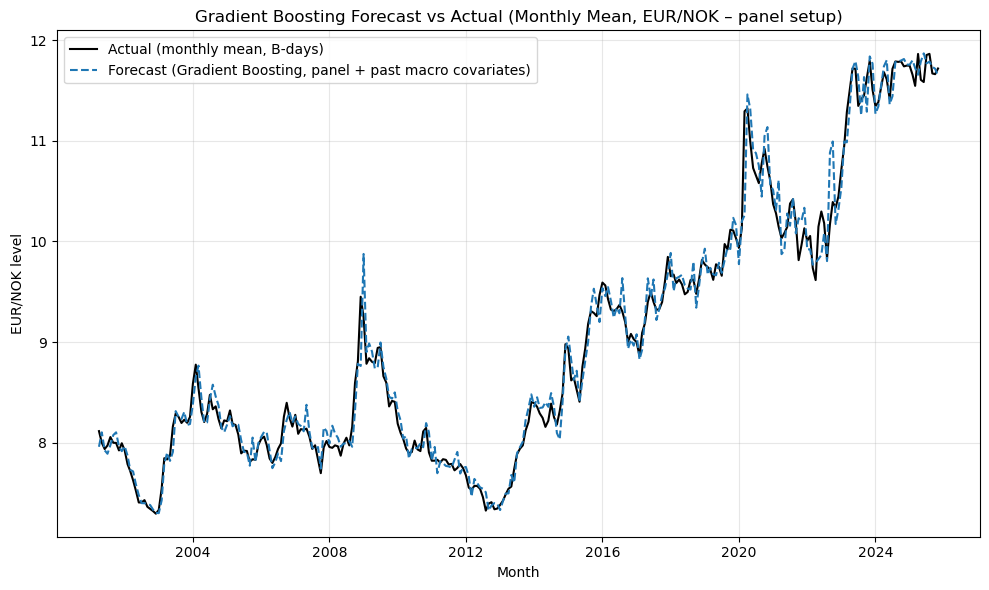

Saved: GB_M_daily_panel_pastcov.png
Saved: GB_M_daily_panel_pastcov.pdf


In [5]:
# =========================================
# Gradient Boosting – EUR/NOK walk-forward (monthly, levels) with daily panel + macro covariates
# PARALLEL OUTER LOOP
# Cross-learning analogue for GB:
#   - Target: EUR_NOK (single series)
#   - Panel predictors: Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy + EUR_NOK lags
#   - Macros: Q, d_pi, dI_t as past-only covariates
#   - Data: daily (calendar days), forward-filled
#   - Cut: last business day of previous month (based on EUR_NOK B-days)
#   - Forecast: recursive daily next-month -> aggregate to monthly mean over business days
#   - No future covariate paths -> all non-target predictors frozen at last observed level
#   - Metrics: Observations, RMSE, MAE, Directional accuracy
#   - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
#   - Plot: Actual (black) vs Forecast (blue dashed), no intervals
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    m_freq: str = "M"          # Monthly evaluation
    min_hist_days: int = 400   # More history for stable GB with many predictors
    max_lags: int = 20         # Number of daily lags for each predictor
    max_horizon: int = 64      # Must exceed longest month (~31 days)

    # Gradient Boosting hyperparameters
    n_estimators: int = 1500
    learning_rate: float = 0.03
    max_depth: int = 3
    subsample: float = 0.8
    min_samples_leaf: int = 2
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "GB_M_daily_panel_pastcov.png"
    fig_pdf: str = "GB_M_daily_panel_pastcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
PANEL_SERIES = [
    "EUR_NOK",
    "Brent",
    "VIX",
    "StoxEurope",
    "SP500",
    "OSEBX",
    "OBX_Energy",
]
MACRO_COLS = ["Q", "d_pi", "dI_t"]

ALL_PREDICTORS = PANEL_SERIES + MACRO_COLS  # All used as lagged predictors

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading: daily wide DF + EUR_NOK business-day series
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV. Expected columns:
      Date, EUR_NOK, Q, d_pi, dI_t, Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (for cuts and monthly ground truth)
      DF_d : daily (D) wide DataFrame with PANEL_SERIES + MACRO_COLS
             calendar days, forward-filled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date"} | set(ALL_PREDICTORS)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types
    for col in ALL_PREDICTORS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK (truth / aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DF_d (calendar days, forward-filled)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Feature engineering: multivariate lag matrix
# -----------------------------
def make_lag_matrix(
    df_hist: pd.DataFrame,
    predictors: List[str],
    max_lags: int
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Build X, y for one-step ahead daily forecasting of EUR_NOK.

    For each t:
      X_t = stacked lags of all predictors (past-only):
        [pred1_{t-1..t-L}, pred2_{t-1..t-L}, ...]
      y_t = EUR_NOK_t
    """
    work = df_hist[predictors].copy()
    lag_cols: List[str] = []

    for var in predictors:
        for k in range(1, max_lags + 1):
            name = f"{var}_lag{k}"
            work[name] = work[var].shift(k)
            lag_cols.append(name)

    work = work.dropna()
    X = work[lag_cols].values
    y = work[TARGET_SERIES].values
    return X, y, lag_cols

# -----------------------------
# Gradient Boosting one-step model
# -----------------------------
def fit_gb_one_step(df_hist_daily: pd.DataFrame) -> Tuple[GradientBoostingRegressor, List[str]]:
    """Fit GB for one-step daily prediction using lags of panel + macros."""
    X, y, lag_cols = make_lag_matrix(df_hist_daily, ALL_PREDICTORS, CFG.max_lags)

    model = GradientBoostingRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        min_samples_leaf=CFG.min_samples_leaf,
        random_state=CFG.random_state,
    )
    model.fit(X, y)
    return model, lag_cols

def recursive_daily_forecast(
    model: GradientBoostingRegressor,
    df_hist_daily: pd.DataFrame,
    H: int,
) -> pd.Series:
    """
    Produce H daily forecasts recursively.

    Anti-leakage rule:
      - Panel series and macros are treated as past-only covariates.
      - During recursion all non-target predictors are frozen at their last observed level.
    """
    hist = df_hist_daily[ALL_PREDICTORS].copy()

    # Last observed levels for all predictors (frozen); target updated each step
    last_vals = hist.iloc[-1].to_dict()

    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")

        row_feats = []
        for var in ALL_PREDICTORS:
            lags = hist[var].iloc[-CFG.max_lags:][::-1].values
            row_feats.extend(lags.tolist())

        x = np.array(row_feats, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        new_row = last_vals.copy()
        new_row[TARGET_SERIES] = yhat
        new_idx = hist.index[-1] + pd.Timedelta(days=1)

        hist = pd.concat([hist, pd.DataFrame([new_row], index=[new_idx])])

    return pd.Series(preds)

# -----------------------------
# Monthly walk-forward using GB + panel/macros (past-only)
# PARALLEL outer loop
# -----------------------------
def walk_forward_gb_monthly_panel_pastcov_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    """
    For each calendar month m:
      - cut at last business day of previous month
      - fit GB on daily history up to cut (EUR_NOK + panel + macros, lagged)
      - recursively forecast full next month at daily frequency
      - aggregate to business-day monthly mean and compare to truth

    Outer loop is parallelized: each month is computed independently.
    """
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    def _process_one_month(m: pd.Period):
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(m), None, "no_cut_in_prev_month")

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] < CFG.min_hist_days:
            return (str(m), None, f"hist<{CFG.min_hist_days}")

        # Business days inside target month
        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            return (str(m), None, "no_bdays_in_month")
        y_true = float(S_b.loc[idx_m_b].mean())

        # Horizon = full calendar month length (inclusive)
        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(m), None, f"horizon_invalid(H={H})")

        # Fit GB and forecast recursively
        model, _ = fit_gb_one_step(hist_df)
        pf = recursive_daily_forecast(model, hist_df, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        # Aggregate forecast to business-day mean
        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            return (str(m), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(m), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_month)(m) for m in months
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if str(m) not in rows]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK – GB panel + past macro covariates) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple Newey–West/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """Random walk benchmark = previous month's observed level (y_{t-1})."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (GB panel setup, monthly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (monthly mean)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"], color="tab:blue", linestyle="--",
        label="Forecast (Gradient Boosting, panel + past macro covariates)"
    )

    plt.title("Gradient Boosting Forecast vs Actual (Monthly Mean, EUR/NOK – panel setup)")
    plt.xlabel("Month")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Load data
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # 2) Monthly walk-forward and evaluation (parallel outer loop)
    df_eval = walk_forward_gb_monthly_panel_pastcov_parallel(S_b, DF_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    # 3) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # 4) Plot
    plot_monthly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()


## GB_Fx-Quarterly_panel



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['EUR_NOK', 'OSEBX', 'SP500', 'OBX_Energy', 'Brent', 'Q', 'dI_t', 'VIX', 'StoxEurope', 'd_pi']

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter
  2000Q2: hist<400
  2000Q3: hist<400
  2000Q4: hist<400
  2001Q1: hist<400

=== Model performance (quarterly mean, EUR/NOK – GB panel + past macro covariates) ===
Observations: 99
RMSE (level): 0.246577
MAE  (level): 0.177276
Directional accuracy: 70/98 (71.4%)

=== Diebold–Mariano vs Random Walk (GB panel setup, quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: 0.2000
p-value     : 0.8415


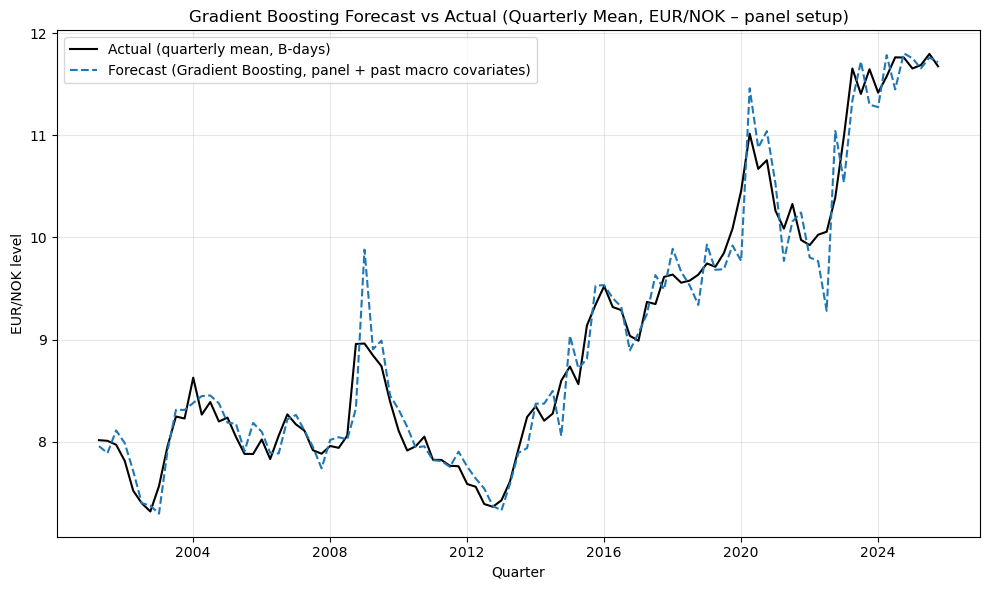

Saved: GB_Q_daily_panel_pastcov.png
Saved: GB_Q_daily_panel_pastcov.pdf


In [6]:
# =========================================
# Gradient Boosting – EUR/NOK walk-forward (quarterly, levels) with daily panel + macro covariates
# PARALLEL OUTER LOOP
# Cross-learning analogue for GB:
#   - Target: EUR_NOK (single series)
#   - Panel predictors: Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy + EUR_NOK lags
#   - Macros: Q, d_pi, dI_t as past-only covariates
#   - Data: daily (calendar days), forward-filled
#   - Cut: last business day of previous quarter (based on EUR_NOK B-days)
#   - Forecast: recursive daily next-quarter -> aggregate to quarterly mean over business days
#   - No future covariate paths -> all non-target predictors frozen at last observed level
#   - Metrics: Observations, RMSE, MAE, Directional accuracy
#   - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
#   - Plot: Actual (black) vs Forecast (blue dashed), no intervals
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    q_freq: str = "Q-DEC"      # Quarterly evaluation
    min_hist_days: int = 400   # More history for stable GB with many predictors
    max_lags: int = 20         # Number of daily lags for each predictor
    max_horizon: int = 128     # Must exceed longest quarter (~92 days)

    # Gradient Boosting hyperparameters
    n_estimators: int = 1800
    learning_rate: float = 0.03
    max_depth: int = 3
    subsample: float = 0.8
    min_samples_leaf: int = 2
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "GB_Q_daily_panel_pastcov.png"
    fig_pdf: str = "GB_Q_daily_panel_pastcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
PANEL_SERIES = [
    "EUR_NOK",
    "Brent",
    "VIX",
    "StoxEurope",
    "SP500",
    "OSEBX",
    "OBX_Energy",
]
MACRO_COLS = ["Q", "d_pi", "dI_t"]

ALL_PREDICTORS = PANEL_SERIES + MACRO_COLS  # All used as lagged predictors

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading: daily wide DF + EUR_NOK business-day series
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV. Expected columns:
      Date, EUR_NOK, Q, d_pi, dI_t, Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (for cuts and quarterly ground truth)
      DF_d : daily (D) wide DataFrame with PANEL_SERIES + MACRO_COLS
             calendar days, forward-filled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date"} | set(ALL_PREDICTORS)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types
    for col in ALL_PREDICTORS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK (truth/aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DF_d (calendar days, forward-filled)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Feature engineering: multivariate lag matrix
# -----------------------------
def make_lag_matrix(
    df_hist: pd.DataFrame,
    predictors: List[str],
    max_lags: int
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Build X, y for one-step ahead daily forecasting of EUR_NOK.

    For each t:
      X_t = stacked lags of all predictors (past-only):
        [pred1_{t-1..t-L}, pred2_{t-1..t-L}, ...]
      y_t = EUR_NOK_t
    """
    work = df_hist[predictors].copy()
    lag_cols: List[str] = []

    for var in predictors:
        for k in range(1, max_lags + 1):
            name = f"{var}_lag{k}"
            work[name] = work[var].shift(k)
            lag_cols.append(name)

    work = work.dropna()
    X = work[lag_cols].values
    y = work[TARGET_SERIES].values
    return X, y, lag_cols

# -----------------------------
# Gradient Boosting one-step model
# -----------------------------
def fit_gb_one_step(df_hist_daily: pd.DataFrame) -> Tuple[GradientBoostingRegressor, List[str]]:
    """Fit GB for one-step daily prediction using lags of panel + macros."""
    X, y, lag_cols = make_lag_matrix(df_hist_daily, ALL_PREDICTORS, CFG.max_lags)

    model = GradientBoostingRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        min_samples_leaf=CFG.min_samples_leaf,
        random_state=CFG.random_state,
    )
    model.fit(X, y)
    return model, lag_cols

def recursive_daily_forecast(
    model: GradientBoostingRegressor,
    df_hist_daily: pd.DataFrame,
    H: int,
) -> pd.Series:
    """
    Produce H daily forecasts recursively.

    Anti-leakage rule:
      - Panel series and macros are treated as past-only covariates.
      - During recursion all non-target predictors are frozen at their last observed level.
    """
    hist = df_hist_daily[ALL_PREDICTORS].copy()
    last_vals = hist.iloc[-1].to_dict()  # Frozen predictors snapshot

    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")

        row_feats = []
        for var in ALL_PREDICTORS:
            lags = hist[var].iloc[-CFG.max_lags:][::-1].values
            row_feats.extend(lags.tolist())

        x = np.array(row_feats, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        new_row = last_vals.copy()
        new_row[TARGET_SERIES] = yhat  # Update only target
        new_idx = hist.index[-1] + pd.Timedelta(days=1)

        hist = pd.concat([hist, pd.DataFrame([new_row], index=[new_idx])])

    return pd.Series(preds)

# -----------------------------
# Quarterly walk-forward using GB + panel/macros (past-only)
# PARALLEL outer loop
# -----------------------------
def walk_forward_gb_quarterly_panel_pastcov_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    """
    For each calendar quarter q:
      - cut at last business day of previous quarter
      - fit GB on daily history up to cut (EUR_NOK + panel + macros, lagged)
      - recursively forecast full next quarter at daily frequency
      - aggregate to business-day quarterly mean and compare to truth

    Outer loop is parallelized: each quarter is computed independently.
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    def _process_one_quarter(q: pd.Period):
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(q), None, "no_cut_in_prev_quarter")

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] < CFG.min_hist_days:
            return (str(q), None, f"hist<{CFG.min_hist_days}")

        # Business days inside target quarter
        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            return (str(q), None, "no_bdays_in_quarter")
        y_true = float(S_b.loc[idx_q_b].mean())

        # Horizon = full calendar quarter length
        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(q), None, f"horizon_invalid(H={H})")

        # Fit GB and forecast recursively
        model, _ = fit_gb_one_step(hist_df)
        pf = recursive_daily_forecast(model, hist_df, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            return (str(q), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(q), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_quarter)(q) for q in quarters
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if str(q) not in rows]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK – GB panel + past macro covariates) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true: pd.Series, y_model: pd.Series, y_rw: pd.Series, h: int = 1, loss: str = "mse") -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (GB panel setup, quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Gradient Boosting, panel + past macro covariates)")

    plt.title("Gradient Boosting Forecast vs Actual (Quarterly Mean, EUR/NOK – panel setup)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # Parallel quarterly walk-forward and evaluation
    df_eval = walk_forward_gb_quarterly_panel_pastcov_parallel(S_b, DF_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    dm_against_random_walk(eval_df, loss="mse", h=1)

    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()
